## <b><div style='padding:15px;background-color:#00369c;color:#c5ebdf;border-radius:10px;font-size:120%;text-align: center'>1 | Load & First look </div></b>

### <b><span style='color:#8bb7cf'>1.1 |</span><span style='color:#00369c'> Import Libraries</span></b>  

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import math
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import  train_test_split, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from lazypredict.Supervised import LazyClassifier
import category_encoders as ce
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

print("Libraries imported")

Libraries imported


### <b><span style='color:#8bb7cf'>1.2 |</span><span style='color:#00369c'> Configure Notebook Properties </span></b> 

In [4]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format # Set 2 as max decimals
pd.set_option('display.max_columns',100)          # Set now of columns visible to 100
pd.set_option('display.max_rows',100)          # Set now of rows visible to 100
plotly.offline.init_notebook_mode(connected=True)

### <b><span style='color:#8bb7cf'>1.3 |</span><span style='color:#00369c'> Load Data </span></b> 

In [6]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

submission = data_test[['PassengerId']]

### <b><span style='color:#8bb7cf'>1.4 |</span><span style='color:#00369c'> First view at the Dataframe </span></b>

In [7]:
data_train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e 39.00  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e 24.00  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e 58.00   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e 33.00  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e 16.00  False   

   RoomService  FoodCourt  ShoppingMall      Spa  VRDeck               Name  \
0         0.00       0.00          0.00     0.00    0.00    Maham Ofracculy   
1       109.00       9.00         25.00   549.00   44.00       Juanna Vines   
2        43.00   3,576.00          0.00 6,715.00   49.00      Altark Susent   
3         0.00   1,283.00        371.00 3,329.00  193.00       Solam Susent   
4       303.00      70.00        151.00   565.00    2.00  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

**Features Description** (copied form task data section):

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

**Destination** - The planet the passenger will be debarking to.

**Age** - The age of the passenger.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

**Name** - The first and last names of the passenger.

**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [8]:
data_train.shape

(8693, 14)

The amount of examples will be important for the train/test split threshold

In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


The data have 6 numerical features

### <b><span style='color:#8bb7cf'>1.5 |</span><span style='color:#00369c'> Feature splitting </span></b>

This step is done before the analysis because I don't fully consider this a feature engineering as it is suggested in the feature's description

In [15]:
def feature_split(df): # Splitter function for the PassengerId and Cabin features
    if 'Cabin_Deck' not in df.keys().values: # Avoid multiple iterations of the same df
        df['PassengerId_Group'] = df['PassengerId'].str.split("_", expand = True)[0].astype(int)
        df['PassengerId_GroupNumber'] = df['PassengerId'].str.split("_", expand=True)[1].astype(int)

        df['Cabin_Deck'] = df['Cabin'].str.split("/", expand = True)[0].astype("string")
        df['Cabin_Num'] = df['Cabin'].str.split("/", expand = True)[1].astype("string")
        df['Cabin_Side'] = df['Cabin'].str.split("/", expand = True)[2].astype("string")

    # The function doesn't remove PassengerId because is more convenient for data_test
    return df

In [16]:
data_train = feature_split(data_train)
data_train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e 39.00  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e 24.00  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e 58.00   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e 33.00  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e 16.00  False   

   RoomService  FoodCourt  ShoppingMall      Spa  VRDeck               Name  \
0         0.00       0.00          0.00     0.00    0.00    Maham Ofracculy   
1       109.00       9.00         25.00   549.00   44.00       Juanna Vines   
2        43.00   3,576.00          0.00 6,715.00   49.00      Altark Susent   
3         0.00   1,283.00        371.00 3,329.00  193.00       Solam Susent   
4       303.00      70.00        151.00   565.00    2.00  Willy Santantines   

   Transported  PassengerId_Group  PassengerId_GroupNumber Cabin_Deck  \
0        False                  1                        1          B   
1         True                  2                        1          F   
2        False                  3                        1          A   
3        False                  3                        2          A   
4         True                  4                        1          F   

  Cabin_Num Cabin_Side  
0         0          P  
1         0          S  
2         0          S  
3         0          S  
4         1          S

### <b><span style='color:#8bb7cf'>1.6 |</span><span style='color:#00369c'> Nulls Check </span></b>

In [17]:
data_train.isnull().sum() # Features with many Nulls values might be useless

PassengerId                  0
HomePlanet                 201
CryoSleep                  217
Cabin                      199
Destination                182
Age                        179
VIP                        203
RoomService                181
FoodCourt                  183
ShoppingMall               208
Spa                        183
VRDeck                     188
Name                       200
Transported                  0
PassengerId_Group            0
PassengerId_GroupNumber      0
Cabin_Deck                 199
Cabin_Num                  199
Cabin_Side                 199
dtype: int64

In [18]:
def check_nulls(df): # Function that will be used to plot nulls values
    fig = px.imshow(df.isna().astype(np.int8), color_continuous_scale = ['#304fa7','#8bb7cf'],
                  title = 'HeatMap for Null Values', height = 400)
    fig.show()
    fig = px.bar(x = df.isna().mean().sort_values().index, y = df.isna().mean().sort_values().values, 
               color_discrete_sequence=['#304fa7'], title = 'Null Value ratio feature wise',
               labels = {'x':'Feature','y':'Ratio'}, height = 400)
    #fig.update_layout(height=400)
    fig.show()

In [19]:
check_nulls(data_train)

None of the features have more than 0.025 nulls, so this should not be a problem

### <b><span style='color:#8bb7cf'>1.7 |</span><span style='color:#00369c'> Unique Values Check </span></b>

In [22]:
def check_unique_values(df): # Function that will be used to plot nulls values
    df_numeric = df.select_dtypes(include = "number").nunique().sort_values()
    df_nonNumeric = df.select_dtypes(exclude = "number").nunique().sort_values()
    fig = make_subplots(rows = 1, cols = 2,
                    subplot_titles = ("Unique values per Categorical feature", 
                                    "Unique values per Numerical feature"))
    
    fig.add_trace(go.Bar(x = df_numeric.index, y = df_numeric.values, 
                         marker = dict(color = '#304fa7')), 
                  row = 1, col = 1)
    fig.add_trace(go.Bar(x = df_nonNumeric.index, y = df_nonNumeric.values, 
                         marker = dict(color = '#8bb7cf')),
                  row = 1, col = 2)
    
    fig.show()

In [23]:
check_unique_values(data_train)

* There is a clear difference between the number of possible values of Age and the other numeric features
* Cabin, Name and PassengerId may be useless as they are right now, they should be droped or changed with feature engineering (as I will do later ;) )

### <b><span style='color:#8bb7cf'>1.8 |</span><span style='color:#00369c'> Value Behaviour </span></b>

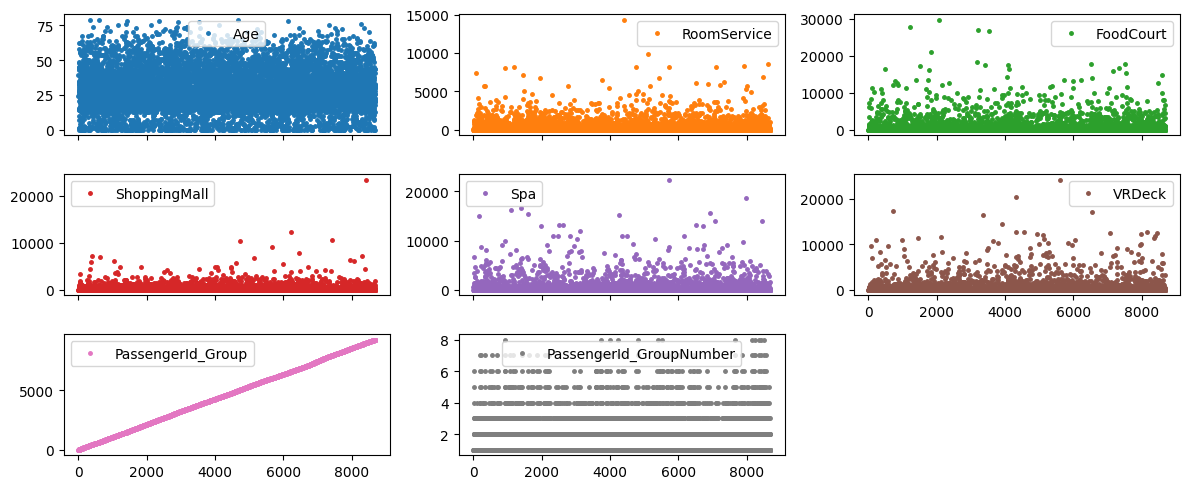

In [24]:
data_train.plot(lw = 0, marker = ".", subplots = True, layout = (-1, 3),
          figsize = (12,5), markersize = 5)
plt.tight_layout()

## <b><div style='padding:15px;background-color:#00369c;color:#c5ebdf;border-radius:10px;font-size:120%;text-align: center'>2 | Univariate Analysis </div></b>

### <b><span style='color:#8bb7cf'>2.1 |</span><span style='color:#00369c'> Categorical Columns </span></b>

In [25]:
def view_categorical(df, categorical_threshold): # Function that plots categorical values
    categorical_features = df.select_dtypes(exclude = "number").nunique()[df.select_dtypes(
        exclude = "number").nunique() <= categorical_threshold].index.tolist()
    
    figsize = (13,5)
    cols = 4
    rows = math.ceil(len(categorical_features) / cols)
    
    plt.subplots(rows,cols,figsize = figsize)
    for i in range(len(categorical_features)):
        plt.subplot(rows,cols,i + 1)
        df[categorical_features[i]].value_counts().sort_values().plot.bar(color = '#304fa7')  
        plt.xticks(rotation = 45)
        plt.title(categorical_features[i])
    
    plt.tight_layout()
    plt.show()

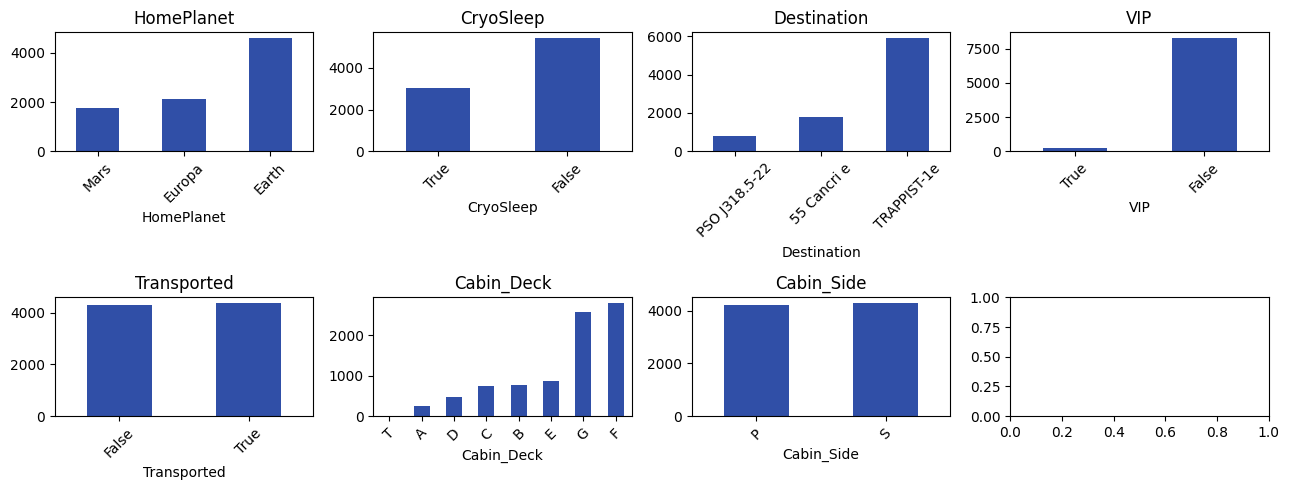

In [26]:
categorical_threshold = 16
view_categorical(data_train, categorical_threshold)

* Earth continues to be the most popular Homeplanet at 2912, we still rock!
* Most people were not asleep
* Some destinations are more popular than others
* Only a few people are VIPs 
* The train data is balanced between transported and not transported people

### <b><span style='color:#8bb7cf'>2.2 |</span><span style='color:#00369c'> Numerical Columns </span></b>

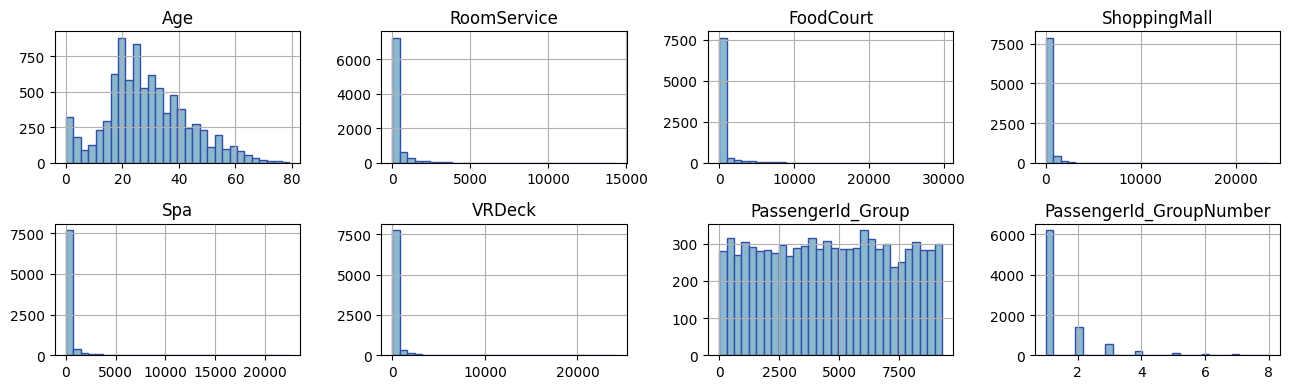

In [27]:
figsize_val = (13,4)
layout_val = (-1, 4)
data_train.hist(bins = 30, figsize = figsize_val, layout = layout_val, 
                edgecolor = '#304fa7', color = '#8bb7cf')
plt.tight_layout()

There may be some outliers

In [172]:
data_train['Age'].isnull().sum()

np.int64(179)

<Axes: xlabel='Age', ylabel='count'>

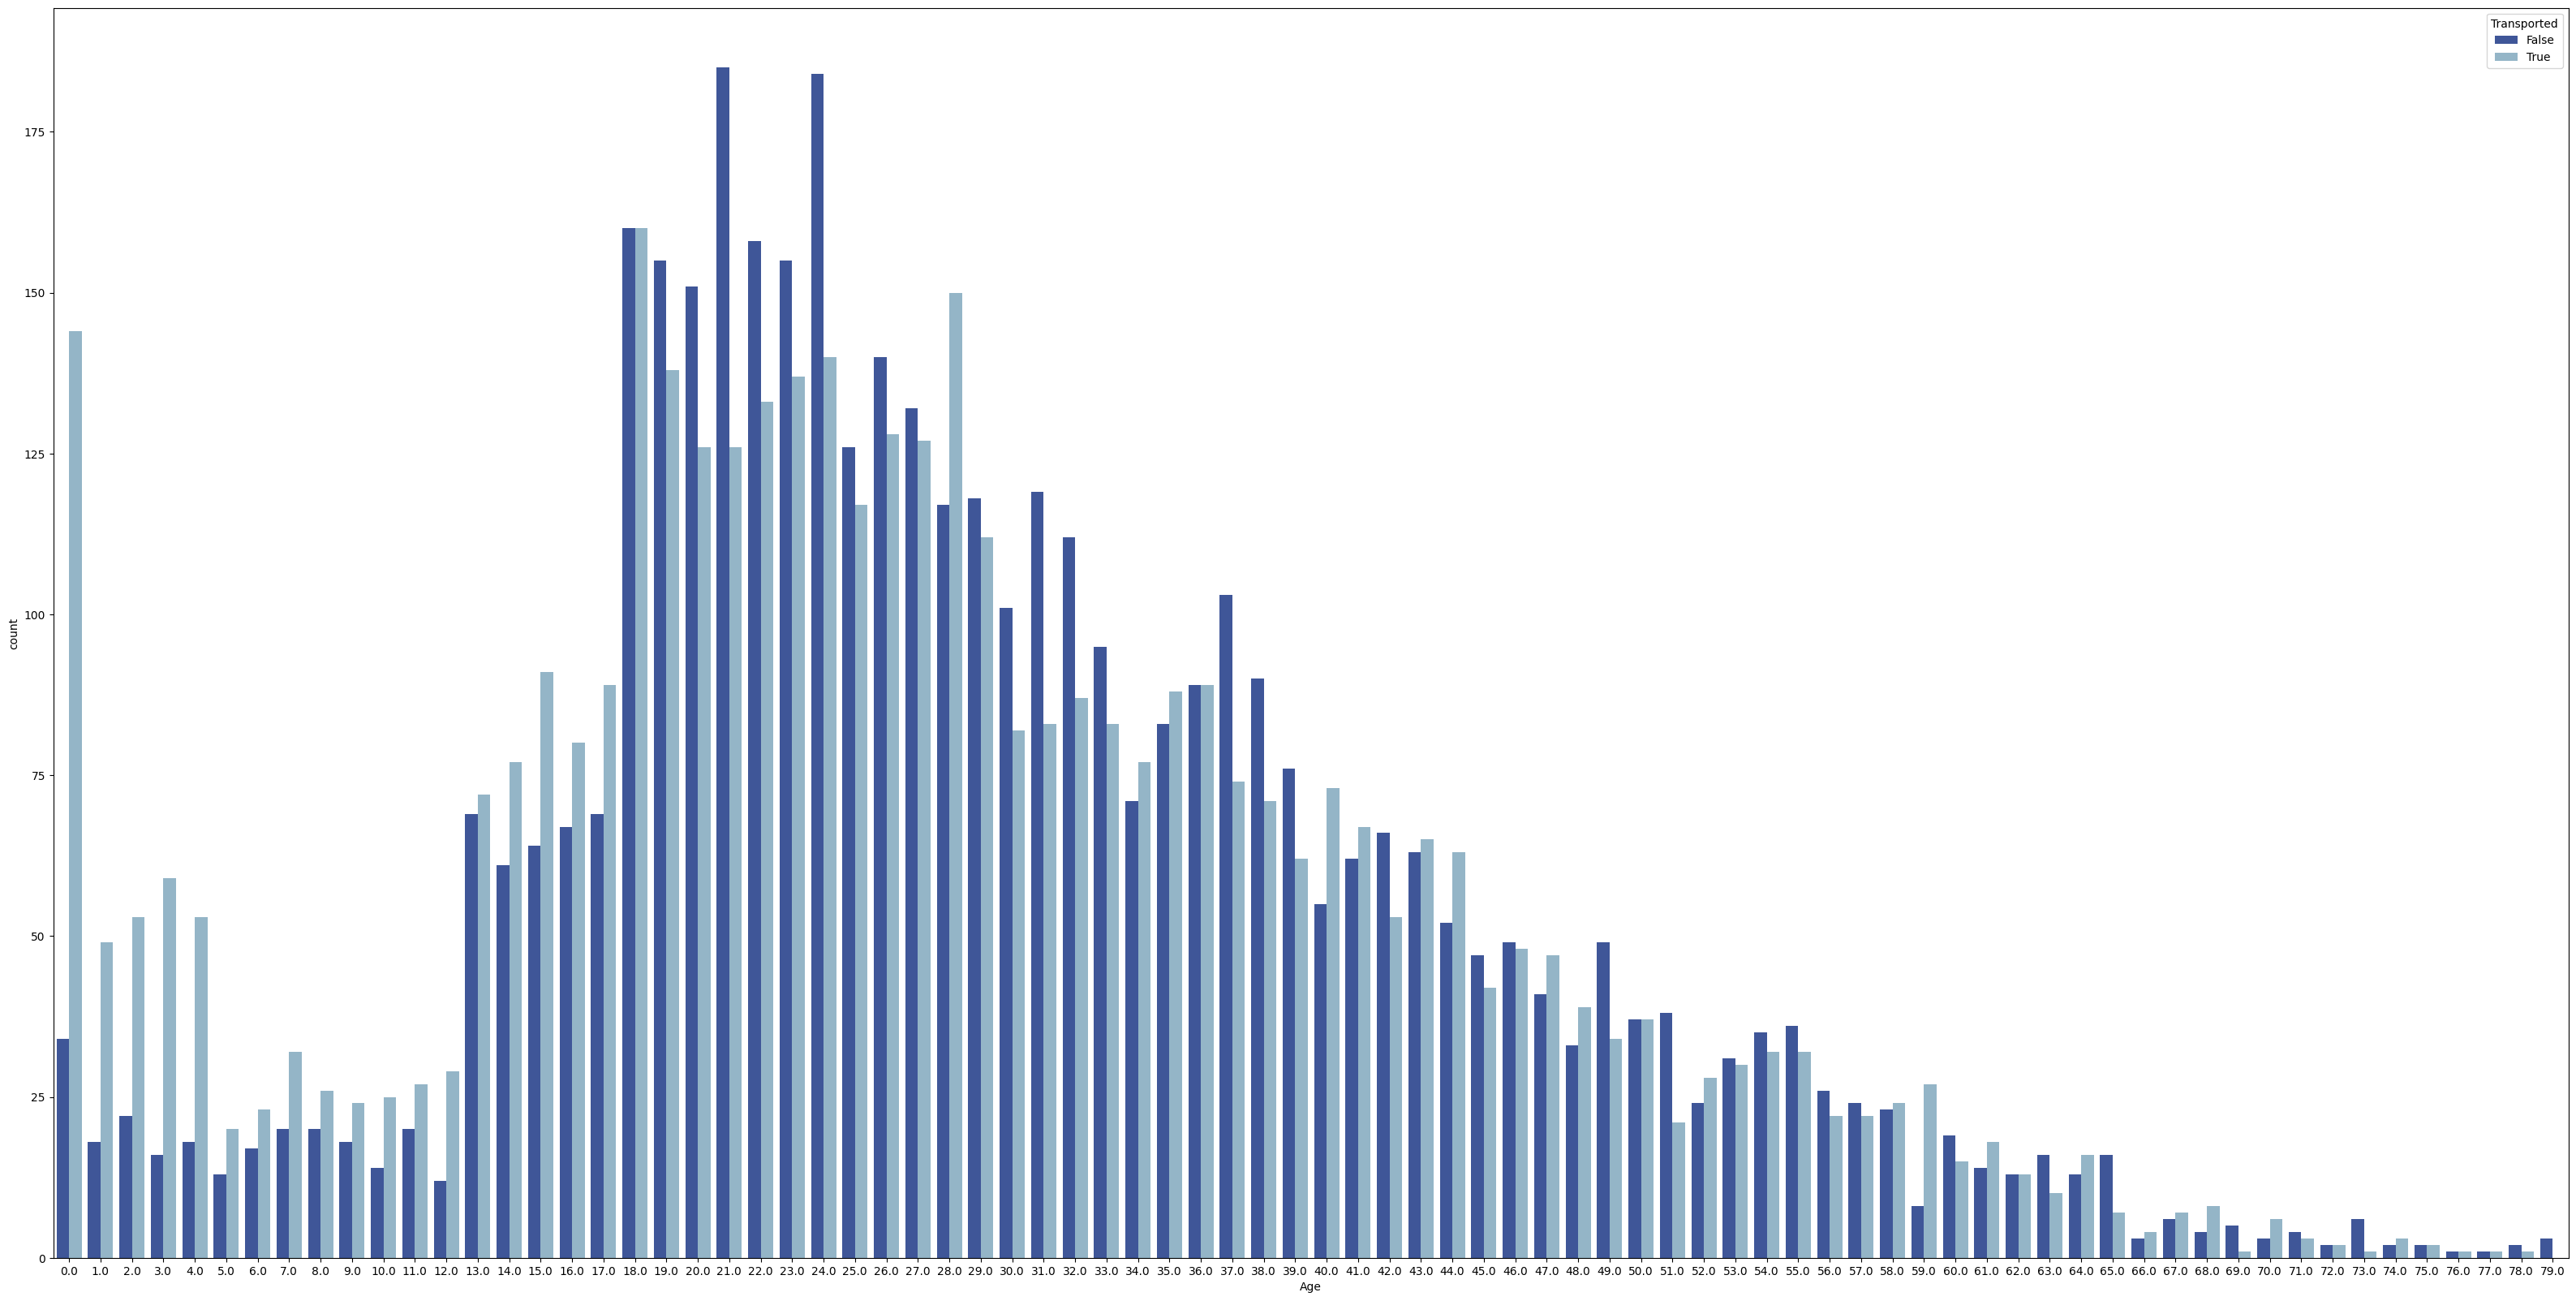

In [169]:
plt.figure(figsize=(40,20))
sns.countplot(data=data_train, x='Age', hue="Transported", palette = ['#304fa7','#8bb7cf'])

People < 18 years tend to be transported

### <b><span style='color:#8bb7cf'>2.3 |</span><span style='color:#00369c'> Outliers Check </span></b>

In [29]:
def check_outliers(df):
    df = df[(df.select_dtypes(include = 'number').columns).to_list()]
    
    upper_threshold = df.quantile(0.75) + 1.5 * (df.quantile(0.75) - df.quantile(0.25))
    lower_threshold = df.quantile(0.25) - 1.5 * (df.quantile(0.75) - df.quantile(0.25))

    for i in df.select_dtypes(include = 'number'):
        print('\nColumn -> ',i,'')   
        x = df[(df[i] < round(lower_threshold[i],2)) | (df[i] > round(upper_threshold[i],2))][i].to_list()
        print('No of Outliers presesnt -> ',len(x))
        print('\n','*' * 10)

In [30]:
check_outliers(data_train)


Column ->  Age 
No of Outliers presesnt ->  77

 **********

Column ->  RoomService 
No of Outliers presesnt ->  1861

 **********

Column ->  FoodCourt 
No of Outliers presesnt ->  1823

 **********

Column ->  ShoppingMall 
No of Outliers presesnt ->  1829

 **********

Column ->  Spa 
No of Outliers presesnt ->  1788

 **********

Column ->  VRDeck 
No of Outliers presesnt ->  1809

 **********

Column ->  PassengerId_Group 
No of Outliers presesnt ->  0

 **********

Column ->  PassengerId_GroupNumber 
No of Outliers presesnt ->  493

 **********


Some features have a lot of outliers, which could be a problem

In [31]:
def limit_outliers(df):
    # Cap RoomService at 9000
    df.loc[df.RoomService.gt(9000), 'RoomService'] = 9000

    # Cap FoodCourt at 22000
    df.loc[df.FoodCourt.gt(22000), 'FoodCourt'] = 22000

    # Cap ShoppingMall at 11000
    df.loc[df.ShoppingMall.gt(11000), 'ShoppingMall'] = 11000

    # Cap Spa at 17000
    df.loc[df.Spa.gt(17000), 'Spa'] = 17000

    # Cap VRDeck at 21000
    df.loc[df.VRDeck.gt(21000), 'VRDeck'] = 21000
    
    return df

### <b><span style='color:#8bb7cf'>2.4 |</span><span style='color:#00369c'> Balanced Check </span></b>

In [32]:
target = data_train[['Transported']].value_counts(normalize = True).round(decimals = 3) * 100

pal, color = ['#304fa7','#8bb7cf'], ['#304fa7','#8bb7cf']
fig = go.Figure()

fig.add_trace(go.Pie(labels = target.index, values = target, hole = .5, 
                     showlegend = True, sort = False, 
                     marker = dict(colors = color,line = dict(color = pal,width = 1)),
                     hovertemplate = "%{label} Transported: %{value:.2f}%<extra></extra>"))

#fig.show()
plotly.offline.iplot(fig)

Seems really well balanced

## <b><div style='padding:15px;background-color:#00369c;color:#c5ebdf;border-radius:10px;font-size:120%;text-align: center'>3 | Multivariate Relationship </div></b>

### <b><span style='color:#8bb7cf'>3.1 |</span><span style='color:#00369c'> Target variable Relation with Categorical variables </span></b>

In [33]:
data_train.select_dtypes(exclude = 'number').columns[data_train.select_dtypes(
        exclude = 'number').nunique() <= categorical_threshold]

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported',
       'Cabin_Deck', 'Cabin_Side'],
      dtype='object')

**These are the features that are going to be analysed**

In [52]:
def feature_stats(df, feature, target):
    # Calculate overall percentages for the feature-target combinations
    overall_percent = df.groupby([feature, target]).size() / len(df) * 100
    overall_percent = overall_percent.reset_index(name='Overall_Percent')

    # Calculate the category size and total size for each feature
    category_size = df.groupby([feature, target]).size().reset_index(name='category_size')
    total_size = df.groupby([feature]).size().reset_index(name='Total')

    # Merge the category size with the total size
    values_per_group = pd.merge(category_size, total_size, on=feature)
    
    # Calculate the category percentage
    values_per_group['Category_Percent'] = (values_per_group['category_size'] / values_per_group['Total']) * 100

    # Merge the overall percentage into the final DataFrame
    values_final = pd.merge(values_per_group, overall_percent, on=[feature, target])

    # Create the pivot table directly from the merged data
    values_pivoted = values_final.pivot_table(index=target, columns=feature,
                                              values=['category_size', 'Category_Percent', 'Overall_Percent'])

    return values_pivoted

#### HomePlanet

In [53]:
#plt.figure(figsize=(13,2))
#sns.countplot(x=data_train['HomePlanet'],hue=data_train['Transported'],palette=sns.color_palette("RdBu"))
px.histogram(data_train, x = 'HomePlanet', color = "Transported", barmode = 'group', 
             color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)
#plt.show()

In [54]:
feature_stats(data_train, 'HomePlanet', 'Transported')

Category_Percent              Overall_Percent               \
HomePlanet             Earth Europa  Mars           Earth Europa  Mars   
Transported                                                              
False                  57.61  34.12 47.70           30.50   8.36  9.65   
True                   42.39  65.88 52.30           22.44  16.15 10.58   

            category_size                  
HomePlanet          Earth   Europa   Mars  
Transported                                
False            2,651.00   727.00 839.00  
True             1,951.00 1,404.00 920.00

#### CryoSleep

In [55]:
px.histogram(data_train, x = 'CryoSleep', color = "Transported", barmode = 'group', 
             color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [56]:
feature_stats(data_train, 'CryoSleep', 'Transported')

Category_Percent       Overall_Percent       category_size  \
CryoSleep              False True            False True          False   
Transported                                                              
False                  67.11 18.24           41.99  6.37      3,650.00   
True                   32.89 81.76           20.58 28.56      1,789.00   

                      
CryoSleep      True   
Transported           
False         554.00  
True        2,483.00

The Cryosleeped people have a high chance to be transported

#### Destination

In [57]:
px.histogram(data_train, x = 'Destination', color = "Transported", barmode = 'group', 
             color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [58]:
feature_stats(data_train, 'Destination', 'Transported')

Category_Percent                           Overall_Percent  \
Destination      55 Cancri e PSO J318.5-22 TRAPPIST-1e     55 Cancri e   
Transported                                                              
False                  39.00         49.62       52.88            8.08   
True                   61.00         50.38       47.12           12.63   

                                      category_size                            
Destination PSO J318.5-22 TRAPPIST-1e   55 Cancri e PSO J318.5-22 TRAPPIST-1e  
Transported                                                                    
False                4.54       35.98        702.00        395.00    3,128.00  
True                 4.61       32.06      1,098.00        401.00    2,787.00

#### VIP

In [59]:
px.histogram(data_train, x = 'VIP', color = "Transported", barmode = 'group', 
             color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [60]:
feature_stats(data_train, 'VIP', 'Transported')

Category_Percent       Overall_Percent       category_size       
VIP                    False True            False True          False  True 
Transported                                                                  
False                  49.37 61.81           47.08  1.41      4,093.00 123.00
True                   50.63 38.19           48.29  0.87      4,198.00  76.00

#### PassengerId_GroupNumber

In [61]:
px.histogram(data_train, x = 'PassengerId_GroupNumber', color = "Transported", barmode = 'group', 
             color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [62]:
feature_stats(data_train, 'PassengerId_GroupNumber', 'Transported')

Category_Percent                                      \
PassengerId_GroupNumber                1     2     3     4     5     6     7   
Transported                                                                    
False                              52.40 44.12 38.18 40.69 45.31 45.33 50.00   
True                               47.60 55.88 61.82 59.31 54.69 54.67 50.00   

                              Overall_Percent                                \
PassengerId_GroupNumber     8               1    2    3    4    5    6    7   
Transported                                                                   
False                   53.85           37.48 7.17 2.51 1.08 0.67 0.39 0.26   
True                    46.15           34.04 9.08 4.06 1.58 0.81 0.47 0.26   

                             category_size                                   \
PassengerId_GroupNumber    8             1      2      3      4     5     6   
Transported                                                                   
False                   0.08      3,258.00 623.00 218.00  94.00 58.00 34.00   
True                    0.07      2,959.00 789.00 353.00 137.00 70.00 41.00   

                                    
PassengerId_GroupNumber     7    8  
Transported                         
False                   23.00 7.00  
True                    23.00 6.00

#### Cabin_Deck

In [63]:
px.histogram(data_train.dropna(subset = ['Cabin_Deck']), x = 'Cabin_Deck', color = "Transported", 
             barmode = 'group', color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [64]:
feature_stats(data_train, 'Cabin_Deck', 'Transported')

Category_Percent                                            \
Cabin_Deck                 A     B     C     D     E     F     G     T   
Transported                                                              
False                  50.39 26.57 31.99 56.69 64.27 56.01 48.38 80.00   
True                   49.61 73.43 68.01 43.31 35.73 43.99 51.62 20.00   

            Overall_Percent                                       \
Cabin_Deck                A    B    C    D    E     F     G    T   
Transported                                                        
False                  1.48 2.38 2.75 3.12 6.48 18.00 14.24 0.05   
True                   1.46 6.58 5.84 2.38 3.60 14.14 15.20 0.01   

            category_size                                                     
Cabin_Deck              A      B      C      D      E        F        G    T  
Transported                                                                   
False              129.00 207.00 239.00 271.00 563.00 1,565.00 1,238.00 4.00  
True               127.00 572.00 508.00 207.00 313.00 1,229.00 1,321.00 1.00

#### Cabin_Side

In [65]:
px.histogram(data_train.dropna(subset = ['Cabin_Side']), x = 'Cabin_Side', color = "Transported", 
             barmode = 'group', color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [66]:
feature_stats(data_train, 'Cabin_Side', 'Transported')

Category_Percent       Overall_Percent       category_size  \
Cabin_Side                 P     S               P     S             P   
Transported                                                              
False                  54.87 44.50           26.55 21.95      2,308.00   
True                   45.13 55.50           21.83 27.38      1,898.00   

                      
Cabin_Side         S  
Transported           
False       1,908.00  
True        2,380.00

### <b><span style='color:#8bb7cf'>3.2 |</span><span style='color:#00369c'> Target variable Relation with Numerical variables </span></b>

In [67]:
def numerical_target_relation(df, target):
    num_features = df.select_dtypes(include = 'number').columns.to_list()
    num_features.append(target)
    
    y = 4
    x = math.ceil((len(num_features) - 1) / y)
    plt.subplots(x,y,figsize = (13,7))
    for i in range(1,len(num_features)-1) :
        plt.subplot(x,y,i)
        sns.pointplot(data = df[num_features], y = num_features[i - 1], x = target, color = '#00369c')

    plt.tight_layout()    
    plt.show()

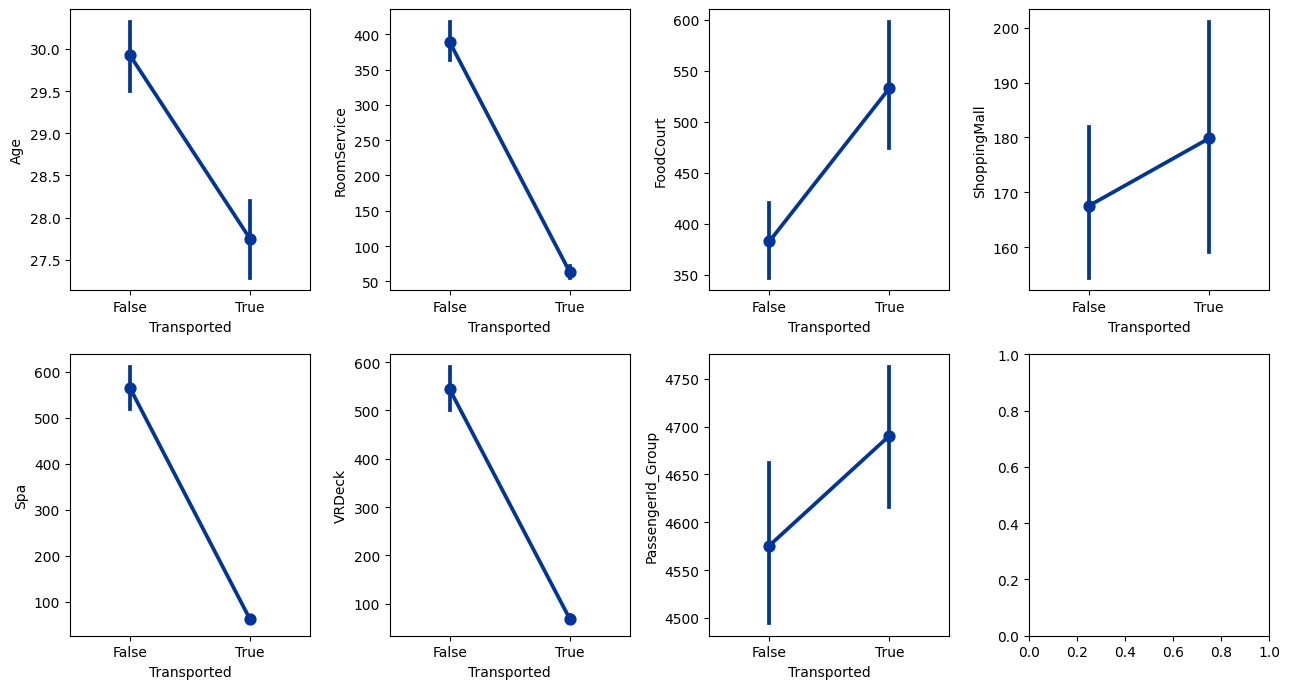

In [68]:
numerical_target_relation(data_train, 'Transported')

* Some features like Age doesn't give much information when comparing transported and not transported people
* But others like Spa could be really helpful

In [69]:
def numerical_parallel_plot(df, target):
    num_features = df.select_dtypes(include = 'number').columns.to_list()
    num_features.append(target)

    plt.figure(figsize = (13,6)) 
    pd.plotting.parallel_coordinates(df[num_features], "Transported", color = ['#304fa7','#8bb7cf'])
    plt.show()

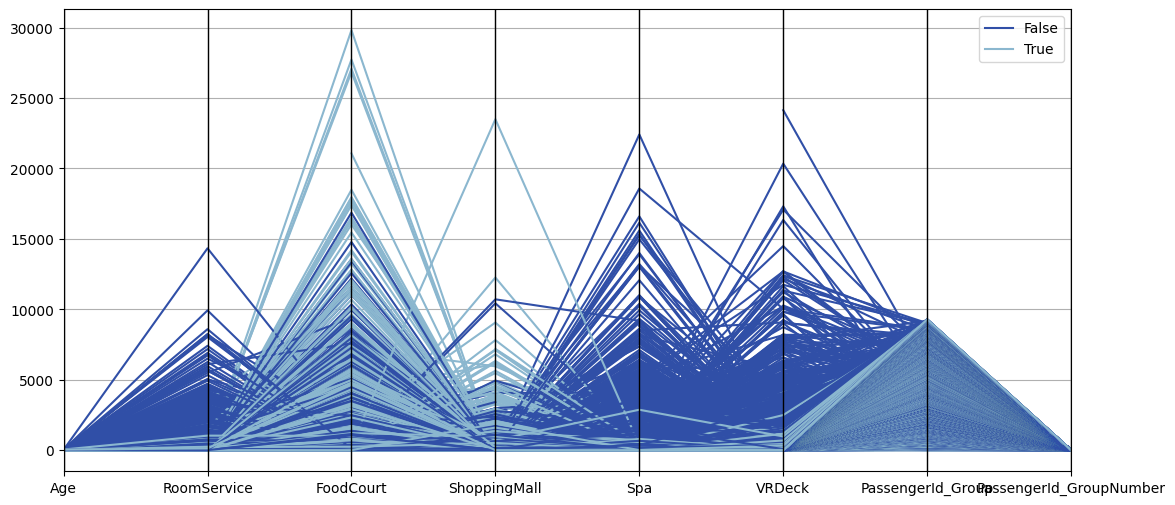

In [70]:
numerical_parallel_plot(data_train, "Transported")

* Transported people tend to have less bill on Spa, VRDeck & RoomService than the non transported people
* Transported people tend to have more bill on FoodCourt & ShoppingMall than the non transported people

### <b><span style='color:#8bb7cf'>3.3 |</span><span style='color:#00369c'> Correllation between numerical features and the target </span></b>

In [71]:
num_features = data_train.select_dtypes(include = 'number').columns.to_list()
num_features.append('Transported')
fig = px.imshow(data_train[num_features].corr().round(2), zmin =- 1, zmax = 1,
                text_auto = True, width = 800, height = 700, 
                aspect = None, color_continuous_scale = 'rdbu')
fig.show()

Transported people seem to have correlation with RoomService, Spa and VRDeck features

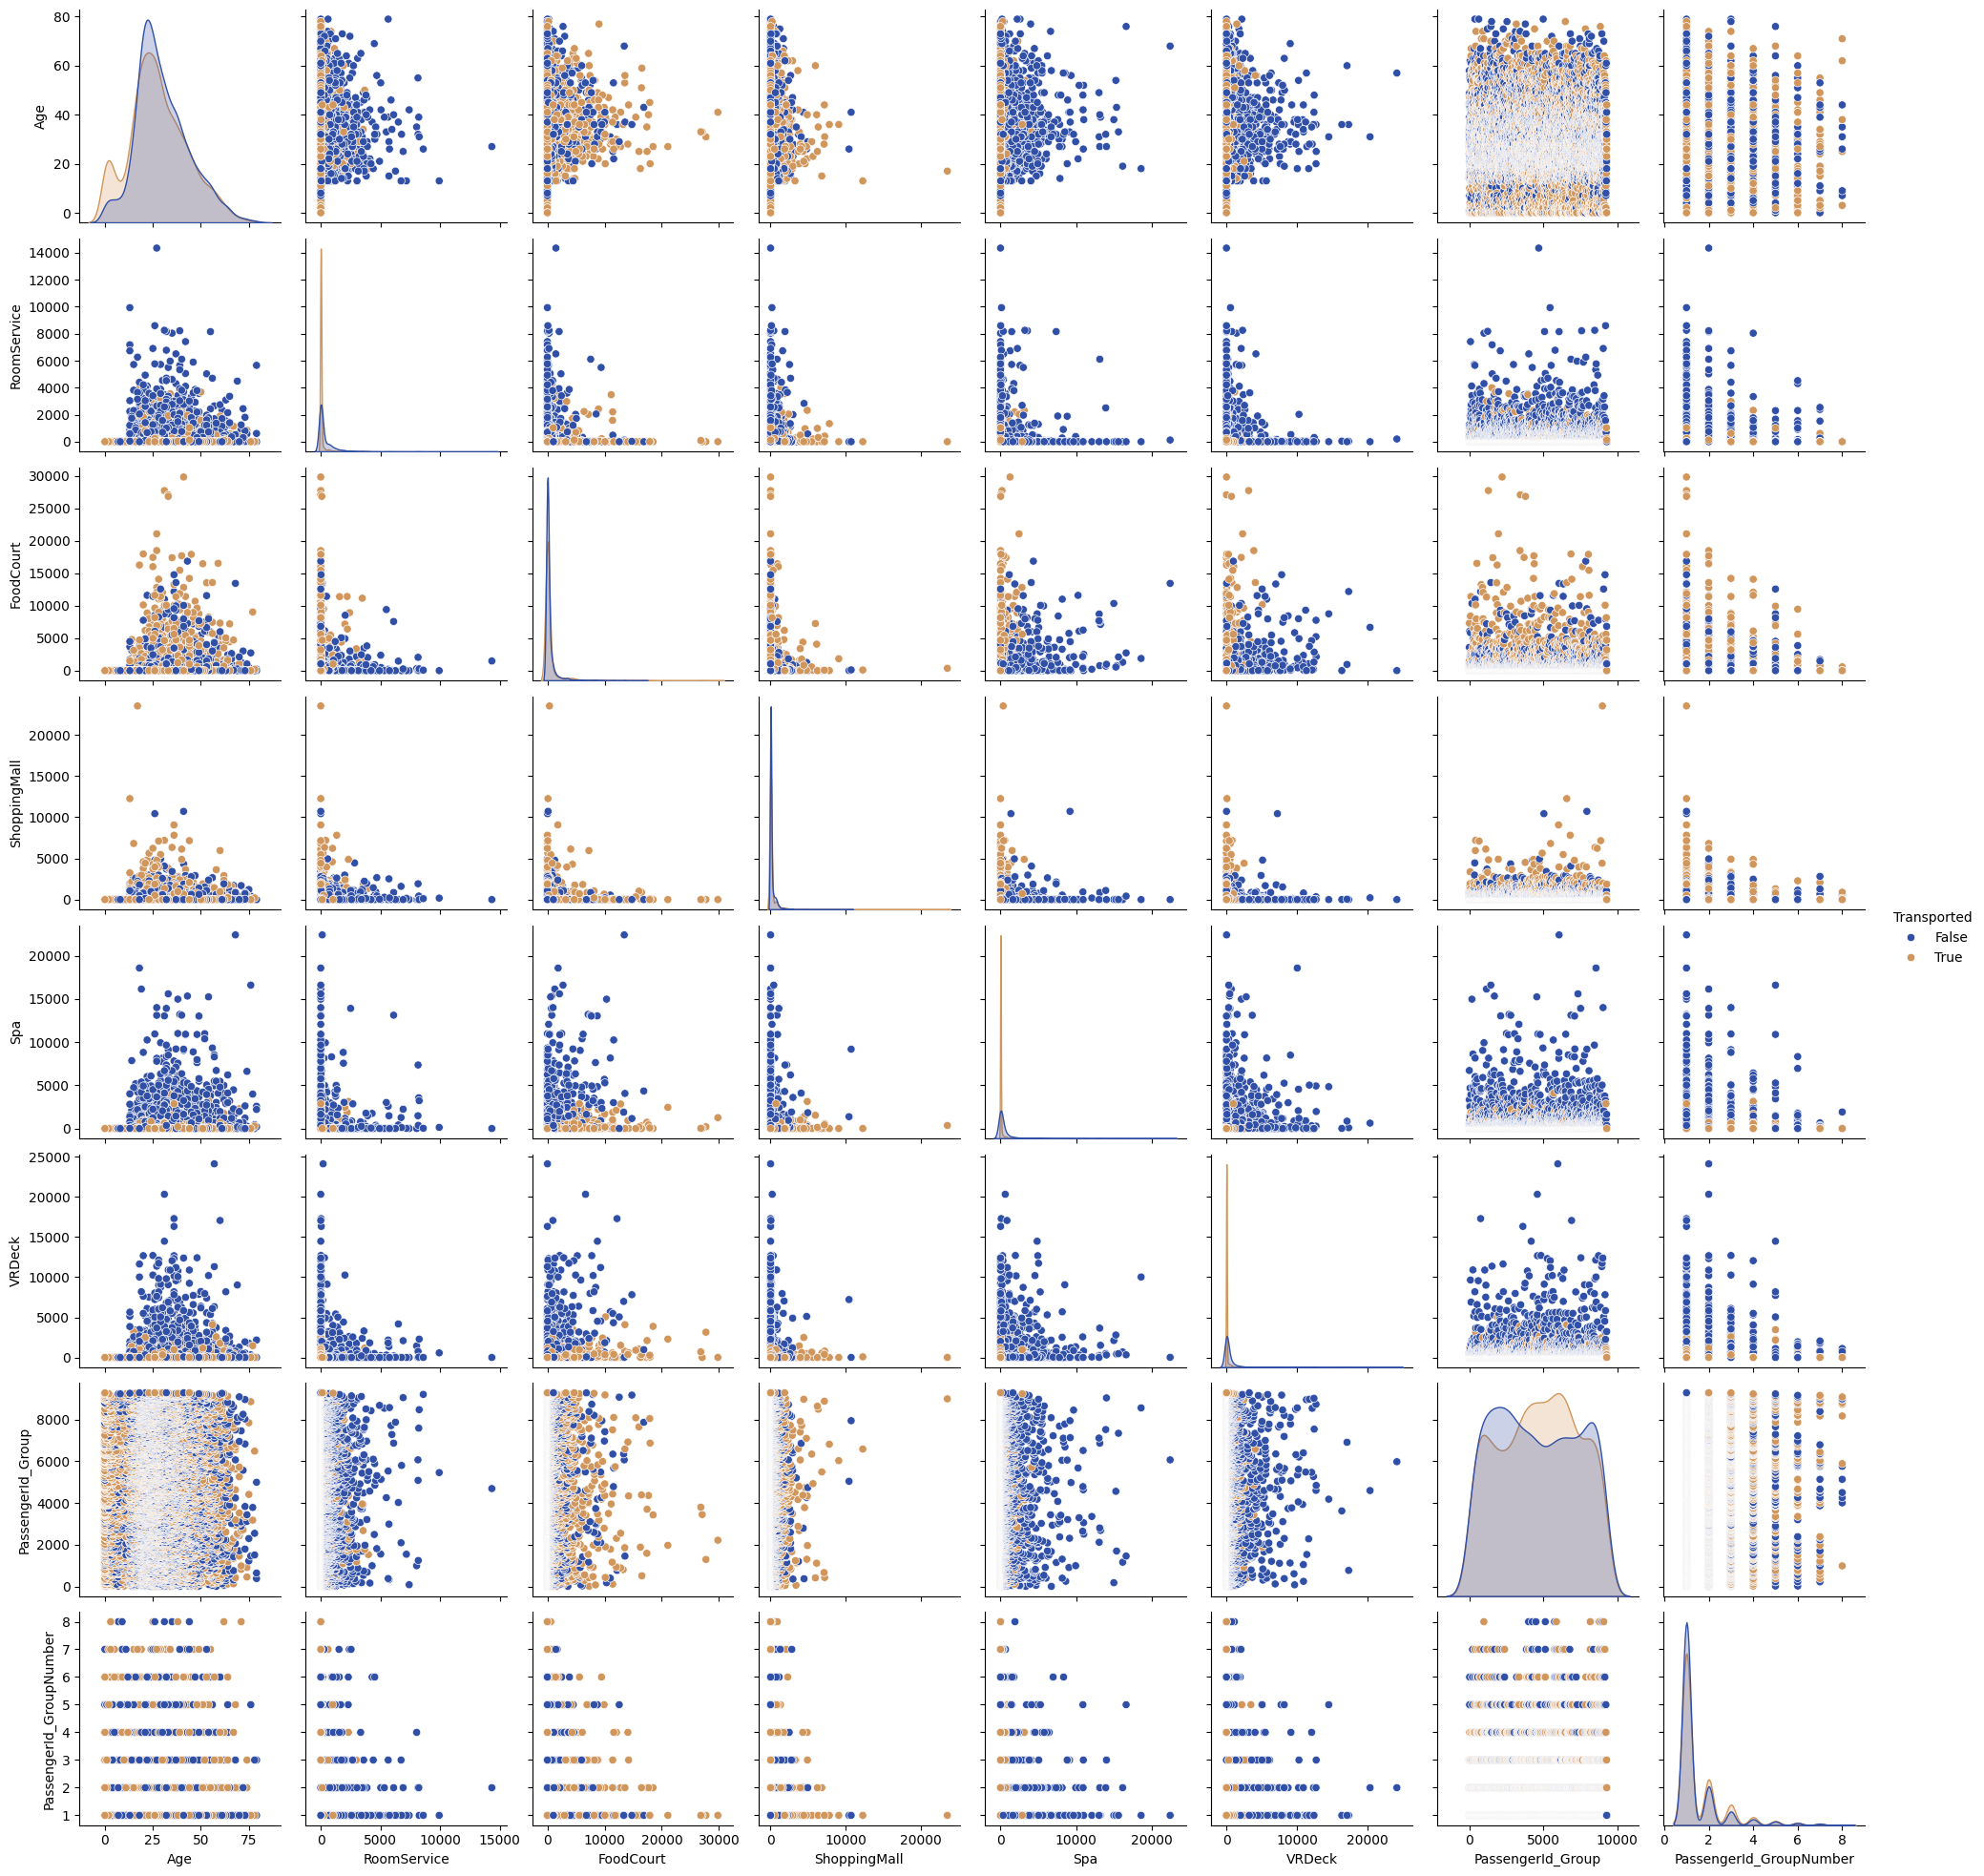

In [72]:
sns.pairplot(data_train[num_features], hue = 'Transported', palette = ['#304fa7','#d1965b'])

plt.show()

## <b><div style='padding:15px;background-color:#00369c;color:#c5ebdf;border-radius:10px;font-size:120%;text-align: center'>4 | Feature Engineering </div></b>

### <b><span style='color:#8bb7cf'>4.1 |</span><span style='color:#00369c'> Delete features that seem to be irrelevant </span></b>

In [73]:
def delete_irrelenvant_features(df): # Deleting irrelevant features
    df = df.drop(columns = ['PassengerId', 'PassengerId_GroupNumber', 'Name', 'Cabin_Num', 'Cabin'],
            axis = 1, errors = 'ignore') 
    return df

### <b><span style='color:#8bb7cf'>4.2 |</span><span style='color:#00369c'> Imputing Null Value </span></b>

In [74]:
def imputeNull(df): # Imputes null values
    # Imputing Nulls from categorical columns
    df['HomePlanet'].fillna(df['HomePlanet'].mode(), inplace = True)
    df['CryoSleep'].fillna(df['CryoSleep'].mode(), inplace = True)
    df['Destination'].fillna(df['Destination'].mode(), inplace = True)
    df['VIP'].fillna(df['VIP'].mode(), inplace=True)
    df['Cabin_Deck'].fillna(df['Cabin_Deck'].mode(), inplace = True)
    df['Cabin_Side'].fillna(df['Cabin_Side'].mode(), inplace = True)
    
    # Imputing Nulls from numerical columns
    df[df['CryoSleep'] == True][['RoomService', 'FoodCourt', 'ShoppingMall', 
                                 'Spa', 'VRDeck']].fillna(0, inplace = True)
    # If you are sleep, you can't buy anything
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['RoomService'].fillna(df['RoomService'].median(), inplace = True)
    df['FoodCourt'].fillna(df['FoodCourt'].median(), inplace = True)
    df['ShoppingMall'].fillna(df['ShoppingMall'].median(), inplace = True)
    df['Spa'].fillna(df['Spa'].median(), inplace = True)
    df['VRDeck'].fillna(df['VRDeck'].median(), inplace = True)
    #df['Cabin_Num'].fillna(df['Cabin_Num'].median(), inplace=True)
    
    return df

### <b><span style='color:#8bb7cf'>4.3 |</span><span style='color:#00369c'> One-hot Encoding </span></b>

In [75]:
def onehot_encoder(df, feature): # Makes one hot encoder with pandas get_dummies function
    dummies = pd.get_dummies(df[feature], prefix = feature)
    df = pd.concat([df,dummies], axis = 1)
    df = df.drop(columns = [feature], axis = 1)
    return df

In [76]:
def onehot_encoder_boolean(df, feature): # Makes one hot encoder in a single column
    dummies = pd.get_dummies(df[feature], prefix = feature, drop_first = True)
    df = pd.concat([df,dummies], axis = 1)
    df = df.drop(columns = [feature], axis = 1)
    return df

In [77]:
def label_encoder_onehot(df): # Makes one hot encoder for every categorical feature
    
    df = onehot_encoder(df, 'HomePlanet')
    df = onehot_encoder_boolean(df, 'CryoSleep')
    df = onehot_encoder(df, 'Destination')
    df = onehot_encoder_boolean(df, 'VIP')
    df = onehot_encoder(df, 'Cabin_Deck')
    df = onehot_encoder(df, 'Cabin_Side')
    
    return df

### <b><span style='color:#8bb7cf'>4.4 |</span><span style='color:#00369c'> Ordinal Encoding </span></b>

In [78]:
def label_encoder_ordinal(df): # Makes ordinal encoder for numeric features
    #This is not numeric, but I wanted to give it a try 
    encoder = OrdinalEncoder(categories=[["A", "B", "C", "D", "E", "F", "G", "T"]], handle_unknown="use_encoded_value",
    unknown_value=-1,)
    df['Cabin_Deck'] = encoder.fit_transform(df[['Cabin_Deck']])
    
    return df

### <b><span style='color:#8bb7cf'>4.5 |</span><span style='color:#00369c'> Target Encoding </span></b>

In [79]:
def target_encoder_features(df_train, y_train, df_test, feature):
    target_encoder = ce.TargetEncoder()
    
    df_train[feature] = target_encoder.fit_transform(
        df_train[feature].astype("object"), y_train)
    df_test[feature] = target_encoder.transform(
        df_test[feature].astype("object"))
    
    df_train[feature].astype("float")
    df_test[feature].astype("float")
    return df_train, df_test

In [80]:
def target_encoder(df_train, y_train, df_test): # Makes target encoding for categorical features
    
    df_train, df_test = target_encoder_features(df_train, y_train, df_test, 'Cabin_Deck')
    
    df_train, df_test = target_encoder_features(df_train, y_train, df_test, 'HomePlanet')
    
    df_train, df_test = target_encoder_features(df_train, y_train, df_test, 'Destination')
    
    df_train, df_test = target_encoder_features(df_train, y_train, df_test, 'Cabin_Side')
    
    return df_train, df_test

In [81]:
#def label_encoder(df): # Label encoder for categorical features (Incorrect way, as they need one-hot)
#    label = LabelEncoder()
#    
#    df['HomePlanet'] = label.fit_transform(df['HomePlanet'])
#    df['CryoSleep'] = label.fit_transform(df['CryoSleep'])
#    df['Destination'] = label.fit_transform(df['Destination'])
#    df['VIP'] = label.fit_transform(df['VIP'])
#    df['Cabin_Deck'] = label.fit_transform(df['Cabin_Deck'].astype(str))
#    df['Cabin_Side'] = label.fit_transform(df['Cabin_Side'].astype(str))
#    
#    return df

### <b><span style='color:#8bb7cf'>4.6 |</span><span style='color:#00369c'> Feature Augmentation </span></b>

In [82]:
def feature_augmentation(df): # Function that creates new features which can be useful
    df['HasPaid'] = (df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']) > 0
    df['Paid'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    df['HasPaid_RoomService'] = (df['RoomService']) > 0
    df['HasPaid_FoodCourt'] = (df['FoodCourt']) > 0
    df['HasPaid_ShoppingMall'] = (df['ShoppingMall']) > 0
    df['HasPaid_Spa'] = (df['Spa']) > 0
    df['HasPaid_VRDeck'] = (df['VRDeck']) > 0
    #df['IsAdult'] = (df['Age']) > 17
    #df["IsEmbryo"] = np.isclose(df["Age"], 0.0)
    #df["IsAlone"] = (df['PassengerId_Group'].value_counts()==1).reindex(df['PassengerId_Group']).tolist()
    
    df['HasPaid'] = df['HasPaid'].astype(int)
    df['HasPaid_RoomService'] = df['HasPaid_RoomService'].astype(int)
    df['HasPaid_FoodCourt'] = df['HasPaid_FoodCourt'].astype(int)
    df['HasPaid_ShoppingMall'] = df['HasPaid_ShoppingMall'].astype(int)
    df['HasPaid_Spa'] = df['HasPaid_Spa'].astype(int)
    df['HasPaid_VRDeck'] = df['HasPaid_VRDeck'].astype(int)
    #df['IsAdult'] = df['IsAdult'].astype(int)
    #df['IsEmbryo'] = df['IsEmbryo'].astype(int)
    #df['IsAlone'] = df['IsAlone'].astype(int)
    return df

### <b><span style='color:#8bb7cf'>4.7 |</span><span style='color:#00369c'> Replace Space with Underscore </span></b>

In [83]:
def replaceSpaces(df):
    df.columns = df.columns.str.replace(' ', '_')
    return df

### <b><span style='color:#8bb7cf'>4.8 |</span><span style='color:#00369c'> Split expenses into bins  </span></b>

In [84]:
def convert_to_bins(df):
    bins = 50
    bin_labels = range(bins)
    
    df['RoomService'] = pd.cut(df['RoomService'], bins=bins, labels=bin_labels)
    df['FoodCourt'] = pd.cut(df['FoodCourt'], bins=bins, labels=bin_labels)
    df['ShoppingMall'] = pd.cut(df['ShoppingMall'], bins=bins, labels=bin_labels)
    df['Spa'] = pd.cut(df['Spa'], bins=bins, labels=bin_labels)
    df['VRDeck'] = pd.cut(df['VRDeck'], bins=bins, labels=bin_labels)
    
    return df

### <b><span style='color:#8bb7cf'>4.9 |</span><span style='color:#00369c'> Preprocess function </span></b>

In [85]:
def preProcess(df, imputingNulls = True):
    df = feature_split(df) # Splits cabin and PassengerId features
    
    df = delete_irrelenvant_features(df) # Removes irrelevant columns 
    
    #df = limit_outliers(df) # Limit outliers
    
    if imputingNulls == True:
        df = imputeNull(df) # Impute null values
    
    df = feature_augmentation(df)
    
    #df = label_encoder(df) # Encode categorical features
    df = label_encoder_onehot(df)
    
    #df = label_encoder_ordinal(df)
    
    #df = convert_to_bins(df)
    
    df = replaceSpaces(df)
    
    return df

In [86]:
def preProcess_analytics(df, imputingNulls = True):
    df = feature_split(df) # Splits cabin and PassengerId features
    
    #df = limit_outliers(df)
    #df = delete_irrelenvant_features(df) # Removes irrelevant columns 
    
    if imputingNulls == True:
        df = imputeNull(df) # Impute null values
    
    df = feature_augmentation(df)
    
    #df = label_encoder(df) # Encode categorical features
    df = label_encoder_onehot(df)
    
    #df = label_encoder_ordinal(df)
    
    df = replaceSpaces(df)
    
    return df

In [87]:
data_aux = data_train.copy()
X_view = preProcess_analytics(data_aux, imputingNulls = True)

In [88]:
px.histogram(X_view.dropna(subset = ['HasPaid']), x = 'HasPaid', color = "Transported", 
             barmode = 'group', color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [89]:
px.histogram(X_view.dropna(subset = ['Paid']), x = 'Paid', color = "Transported", 
             barmode = 'group', color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [90]:
#px.histogram(X_view.dropna(subset = ['HasPaid_RoomService']), x = 'HasPaid_RoomService', color = "Transported", 
#             barmode = 'group', color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [91]:
#px.histogram(X_view.dropna(subset = ['HasPaid_FoodCourt']), x = 'HasPaid_FoodCourt', color = "Transported", 
#             barmode = 'group', color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [92]:
#px.histogram(X_view.dropna(subset = ['HasPaid_ShoppingMall']), x = 'HasPaid_ShoppingMall', color = "Transported", 
#             barmode = 'group', color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [93]:
#px.histogram(X_view.dropna(subset = ['HasPaid_Spa']), x = 'HasPaid_Spa', color = "Transported", 
#             barmode = 'group', color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [94]:
#px.histogram(X_view.dropna(subset = ['HasPaid_VRDeck']), x = 'HasPaid_VRDeck', color = "Transported", 
#             barmode = 'group', color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [95]:
#px.histogram(X_view.dropna(subset = ['IsAdult']), x = 'IsAdult', color = "Transported", 
#             barmode = 'group', color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [96]:
#px.histogram(X_view.dropna(subset = ['IsEmbryo']), x = 'IsEmbryo', color = "Transported", 
#             barmode = 'group', color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

In [97]:
#px.histogram(X_view.dropna(subset = ['IsAlone']), x = 'IsAlone', color = "Transported", 
#             barmode = 'group', color_discrete_sequence = ['#304fa7','#8bb7cf'], height = 300)

## <b><div style='padding:15px;background-color:#00369c;color:#c5ebdf;border-radius:10px;font-size:120%;text-align: center'>5 | ML Model (Imputing Nulls)</div></b>

### <b><span style='color:#8bb7cf'>5.1 |</span><span style='color:#00369c'> Train/Validation Split </span></b>

In [100]:
y = data_train['Transported']
X = data_train.drop(columns = 'Transported', axis = 1)
X_train , X_test , y_train , y_test = train_test_split(X, y, stratify = y,
                                                       random_state = 5, test_size = 0.40)

### <b><span style='color:#8bb7cf'>5.2 |</span><span style='color:#00369c'> Preprocess data </span></b>

In [101]:
#data_test = feature_split(data_test)

#X_train, X_test = target_encoder(X_train, y_train, X_test)
#X, data_test = target_encoder(X, y, data_test)

In [102]:
X_train = preProcess(X_train, imputingNulls = True)
X_test = preProcess(X_test, imputingNulls = True)
X_preProcessed = preProcess(X, imputingNulls = True)

data_test_preProcessed = preProcess(data_test, imputingNulls = True)

In [103]:
X_train.head()

Age  RoomService  FoodCourt  ShoppingMall    Spa   VRDeck  \
5914 23.00       690.00       0.00          0.00 292.00 1,596.00   
351  14.00         3.00       0.00        881.00  25.00     0.00   
533  33.00     1,908.00      33.00          0.00   1.00     4.00   
6653 29.00         0.00       0.00          0.00   0.00     0.00   
8539 64.00        37.00   1,585.00        234.00   0.00    18.00   

      PassengerId_Group  HasPaid     Paid  HasPaid_RoomService  \
5914               6273        1 2,578.00                    1   
351                 384        1   909.00                    1   
533                 568        1 1,946.00                    1   
6653               7015        0     0.00                    0   
8539               9118        1 1,874.00                    1   

      HasPaid_FoodCourt  HasPaid_ShoppingMall  HasPaid_Spa  HasPaid_VRDeck  \
5914                  0                     0            1               1   
351                   0                     1            1               0   
533                   1                     0            1               1   
6653                  0                     0            0               0   
8539                  1                     1            0               1   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  CryoSleep_True  \
5914             False              False             True           False   
351               True              False            False           False   
533              False               True            False           False   
6653             False               True            False            True   
8539              True              False            False           False   

      Destination_55_Cancri_e  Destination_PSO_J318.5-22  \
5914                    False                      False   
351                     False                      False   
533                     False                      False   
6653                    False                      False   
8539                    False                      False   

      Destination_TRAPPIST-1e  VIP_True  Cabin_Deck_A  Cabin_Deck_B  \
5914                     True     False         False         False   
351                      True     False         False         False   
533                      True     False         False         False   
6653                     True     False         False         False   
8539                     True     False         False         False   

      Cabin_Deck_C  Cabin_Deck_D  Cabin_Deck_E  Cabin_Deck_F  Cabin_Deck_G  \
5914         False          True         False         False         False   
351          False         False         False         False          True   
533          False          True         False         False         False   
6653          True         False         False         False         False   
8539         False         False         False         False          True   

      Cabin_Deck_T  Cabin_Side_P  Cabin_Side_S  
5914         False          True         False  
351          False         False          True  
533          False         False          True  
6653         False          True         False  
8539         False          True         False

### <b><span style='color:#8bb7cf'>5.3 |</span><span style='color:#00369c'> Model search </span></b>

In [104]:
clf = LazyClassifier(verbose = 0,
                     ignore_warnings = True,
                     custom_metric = None,
                     predictions = False,
                     random_state = 12,
                     classifiers = 'all')

models, predictions = clf.fit(X_train, X_test ,y_train , y_test)

 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [00:06<00:00,  4.79it/s]

[LightGBM] [Info] Number of positive: 2626, number of negative: 2589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1880
[LightGBM] [Info] Number of data points in the train set: 5215, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503547 -> initscore=0.014190
[LightGBM] [Info] Start training from score 0.014190


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.59it/s]


In [106]:
models

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.80               0.80     0.80      0.80   
LogisticRegression                 0.79               0.79     0.79      0.79   
LinearSVC                          0.79               0.79     0.79      0.79   
CalibratedClassifierCV             0.79               0.79     0.79      0.79   
AdaBoostClassifier                 0.79               0.79     0.79      0.79   
SVC                                0.78               0.78     0.78      0.78   
SGDClassifier                      0.78               0.78     0.78      0.78   
NuSVC                              0.78               0.78     0.78      0.78   
RidgeClassifierCV                  0.77               0.77     0.77      0.77   
RidgeClassifier                    0.77               0.77     0.77      0.77   
LinearDiscriminantAnalysis         0.77               0.77     0.77      0.77   
GaussianNB                         0.77               0.76     0.76      0.76   
RandomForestClassifier             0.76               0.76     0.76      0.76   
QuadraticDiscriminantAnalysis      0.76               0.76     0.76      0.75   
ExtraTreesClassifier               0.75               0.75     0.75      0.75   
KNeighborsClassifier               0.75               0.75     0.75      0.75   
BaggingClassifier                  0.75               0.75     0.75      0.75   
LabelSpreading                     0.74               0.74     0.74      0.74   
LabelPropagation                   0.74               0.74     0.74      0.74   
BernoulliNB                        0.74               0.74     0.74      0.74   
NearestCentroid                    0.73               0.73     0.73      0.73   
DecisionTreeClassifier             0.70               0.70     0.70      0.70   
Perceptron                         0.69               0.69     0.69      0.69   
ExtraTreeClassifier                0.69               0.69     0.69      0.69   
PassiveAggressiveClassifier        0.58               0.58     0.58      0.56   
DummyClassifier                    0.50               0.50     0.50      0.34   

                               Time Taken  
Model                                      
LGBMClassifier                       0.19  
LogisticRegression                   0.02  
LinearSVC                            0.02  
CalibratedClassifierCV               0.06  
AdaBoostClassifier                   0.20  
SVC                                  1.24  
SGDClassifier                        0.03  
NuSVC                                1.32  
RidgeClassifierCV                    0.03  
RidgeClassifier                      0.02  
LinearDiscriminantAnalysis           0.03  
GaussianNB                           0.01  
RandomForestClassifier               0.57  
QuadraticDiscriminantAnalysis        0.02  
ExtraTreesClassifier                 0.39  
KNeighborsClassifier                 0.21  
BaggingClassifier                    0.18  
LabelSpreading                       1.14  
LabelPropagation                     0.91  
BernoulliNB                          0.01  
NearestCentroid                      0.01  
DecisionTreeClassifier               0.04  
Perceptron                           0.01  
ExtraTreeClassifier                  0.02  
PassiveAggressiveClassifier          0.02  
DummyClassifier                      0.01

In [110]:
px.line(data_frame = models[:10], y = ['Accuracy','Balanced Accuracy','ROC AUC','F1 Score'], markers = True)

My first approach would be a LGBMClassifier as it is the best with no tunning

### <b><span style='color:#8bb7cf'>5.4 |</span><span style='color:#00369c'> Model Fit </span></b>

In [111]:
lgbm = LGBMClassifier()
lgbm.fit(X_preProcessed, y)
#lgbm.fit(X_train, y_train, 
#         eval_metric='accuracy', eval_set=[(X_test, y_test)], 
#         early_stopping_rounds = 5)

#lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495


LGBMClassifier()

In [112]:
print('Accuracy on train set: {:.2f}'.format(lgbm.score(X_preProcessed, y)))
#print('Accuracy test set: {:.2f}'.format(lgbm.score(X, y)))
#print('Accuracy on train set: {:.2f}'.format(lgbm.score(X_train, y_train)))
#print('Accuracy test set: {:.2f}'.format(lgbm.score(X_test, y_test)))

#confusion_matrix_restult = confusion_matrix(y_test, y_pred)
#print(confusion_matrix_restult, '<- Confusion matrix')
#print(classification_report(y_test, y_pred))

Accuracy on train set: 0.88


### <b><span style='color:#8bb7cf'>5.5 |</span><span style='color:#00369c'> Model Prediction </span></b>

In [113]:
y_pred = lgbm.predict(data_test_preProcessed)

### <b><span style='color:#8bb7cf'>5.6 |</span><span style='color:#00369c'> Prediction Submit </span></b>

In [114]:
submission['Transported'] = y_pred.astype("bool")
submission.to_csv("submission.csv",index = False)
submission.head()

PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True

## <b><div style='padding:15px;background-color:#00369c;color:#c5ebdf;border-radius:10px;font-size:120%;text-align: center'>6 | ML Model (Dropping Nulls)</div></b>

### <b><span style='color:#8bb7cf'>6.1 |</span><span style='color:#00369c'> Train/Validation Split </span></b>

In [115]:
y = data_train['Transported']
X = data_train.drop(columns = 'Transported', axis = 1)
X_train , X_test , y_train , y_test = train_test_split(X, y, stratify = y,
                                                       random_state = 5, test_size = 0.40)

### <b><span style='color:#8bb7cf'>6.2 |</span><span style='color:#00369c'> Preprocess data </span></b>

In [116]:
#data_test = feature_split(data_test)

#X_train, X_test = target_encoder(X_train, y_train, X_test)
#X, data_test = target_encoder(X, y, data_test)

In [117]:
X_train.dropna()
X_test.dropna()
data_test_preProcessed.dropna()

X_train = preProcess(X_train, imputingNulls = False)
X_test = preProcess(X_test, imputingNulls = False)
X_preProcessed = preProcess(X, imputingNulls = False)

data_test_preProcessed = preProcess(data_test, imputingNulls = False)

In [118]:
X_train.head()

Age  RoomService  FoodCourt  ShoppingMall    Spa   VRDeck  \
5914 23.00       690.00       0.00          0.00 292.00 1,596.00   
351  14.00         3.00       0.00        881.00  25.00     0.00   
533  33.00     1,908.00      33.00          0.00   1.00     4.00   
6653 29.00         0.00       0.00          0.00   0.00     0.00   
8539 64.00        37.00   1,585.00        234.00   0.00    18.00   

      PassengerId_Group  HasPaid     Paid  HasPaid_RoomService  \
5914               6273        1 2,578.00                    1   
351                 384        1   909.00                    1   
533                 568        1 1,946.00                    1   
6653               7015        0     0.00                    0   
8539               9118        1 1,874.00                    1   

      HasPaid_FoodCourt  HasPaid_ShoppingMall  HasPaid_Spa  HasPaid_VRDeck  \
5914                  0                     0            1               1   
351                   0                     1            1               0   
533                   1                     0            1               1   
6653                  0                     0            0               0   
8539                  1                     1            0               1   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  CryoSleep_True  \
5914             False              False             True           False   
351               True              False            False           False   
533              False               True            False           False   
6653             False               True            False            True   
8539              True              False            False           False   

      Destination_55_Cancri_e  Destination_PSO_J318.5-22  \
5914                    False                      False   
351                     False                      False   
533                     False                      False   
6653                    False                      False   
8539                    False                      False   

      Destination_TRAPPIST-1e  VIP_True  Cabin_Deck_A  Cabin_Deck_B  \
5914                     True     False         False         False   
351                      True     False         False         False   
533                      True     False         False         False   
6653                     True     False         False         False   
8539                     True     False         False         False   

      Cabin_Deck_C  Cabin_Deck_D  Cabin_Deck_E  Cabin_Deck_F  Cabin_Deck_G  \
5914         False          True         False         False         False   
351          False         False         False         False          True   
533          False          True         False         False         False   
6653          True         False         False         False         False   
8539         False         False         False         False          True   

      Cabin_Deck_T  Cabin_Side_P  Cabin_Side_S  
5914         False          True         False  
351          False         False          True  
533          False         False          True  
6653         False          True         False  
8539         False          True         False

### <b><span style='color:#8bb7cf'>6.3 |</span><span style='color:#00369c'> Model search </span></b>

In [119]:
clf = LazyClassifier(verbose = 0,
                     ignore_warnings = True,
                     custom_metric = None,
                     predictions = False,
                     random_state = 12,
                     classifiers = 'all')

models, predictions = clf.fit(X_train, X_test ,y_train , y_test)

 84%|█████████████████████████████████████████████████████████████████████▏            | 27/32 [00:06<00:01,  3.45it/s]

[LightGBM] [Info] Number of positive: 2626, number of negative: 2589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1880
[LightGBM] [Info] Number of data points in the train set: 5215, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503547 -> initscore=0.014190
[LightGBM] [Info] Start training from score 0.014190


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.62it/s]


In [120]:
models

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.79               0.79     0.79      0.79   
LogisticRegression                 0.79               0.79     0.79      0.79   
LinearSVC                          0.79               0.79     0.79      0.79   
CalibratedClassifierCV             0.79               0.79     0.79      0.79   
SVC                                0.78               0.78     0.78      0.78   
SGDClassifier                      0.78               0.78     0.78      0.78   
NuSVC                              0.78               0.78     0.78      0.78   
RidgeClassifier                    0.77               0.77     0.77      0.77   
LinearDiscriminantAnalysis         0.77               0.77     0.77      0.77   
RidgeClassifierCV                  0.77               0.77     0.77      0.77   
RandomForestClassifier             0.76               0.76     0.76      0.76   
QuadraticDiscriminantAnalysis      0.76               0.76     0.76      0.76   
AdaBoostClassifier                 0.76               0.76     0.76      0.76   
GaussianNB                         0.76               0.76     0.76      0.75   
ExtraTreesClassifier               0.75               0.75     0.75      0.75   
KNeighborsClassifier               0.75               0.75     0.75      0.75   
BaggingClassifier                  0.74               0.74     0.74      0.74   
BernoulliNB                        0.74               0.74     0.74      0.74   
LabelSpreading                     0.74               0.74     0.74      0.74   
LabelPropagation                   0.74               0.74     0.74      0.73   
NearestCentroid                    0.73               0.73     0.73      0.73   
DecisionTreeClassifier             0.70               0.70     0.70      0.70   
ExtraTreeClassifier                0.68               0.68     0.68      0.68   
Perceptron                         0.56               0.56     0.56      0.56   
DummyClassifier                    0.50               0.50     0.50      0.34   
PassiveAggressiveClassifier        0.49               0.49     0.49      0.44   

                               Time Taken  
Model                                      
LGBMClassifier                       0.09  
LogisticRegression                   0.02  
LinearSVC                            0.02  
CalibratedClassifierCV               0.06  
SVC                                  1.28  
SGDClassifier                        0.03  
NuSVC                                1.34  
RidgeClassifier                      0.02  
LinearDiscriminantAnalysis           0.02  
RidgeClassifierCV                    0.02  
RandomForestClassifier               0.61  
QuadraticDiscriminantAnalysis        0.02  
AdaBoostClassifier                   0.20  
GaussianNB                           0.01  
ExtraTreesClassifier                 0.40  
KNeighborsClassifier                 0.23  
BaggingClassifier                    0.18  
BernoulliNB                          0.01  
LabelSpreading                       1.24  
LabelPropagation                     0.91  
NearestCentroid                      0.01  
DecisionTreeClassifier               0.04  
ExtraTreeClassifier                  0.02  
Perceptron                           0.01  
DummyClassifier                      0.01  
PassiveAggressiveClassifier          0.02

In [121]:
px.line(data_frame = models[:10], y = ['Accuracy','Balanced Accuracy','ROC AUC','F1 Score'], markers = True)

My first approach would be a LGBMClassifier too as it is the best with no tunning

### <b><span style='color:#8bb7cf'>6.4 |</span><span style='color:#00369c'> Model Fit </span></b>

In [122]:
lgbm = LGBMClassifier(random_state = 5)
lgbm.fit(X_preProcessed, y)

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495


LGBMClassifier(random_state=5)

In [123]:
print('Accuracy on train set: {:.2f}'.format(lgbm.score(X_preProcessed, y)))
#print('Accuracy test set: {:.2f}'.format(lgbm.score(X, y)))

#confusion_matrix_restult = confusion_matrix(y_test, y_pred)
#print(confusion_matrix_restult, '<- Confusion matrix')
#print(classification_report(y_test, y_pred))

Accuracy on train set: 0.88


### <b><span style='color:#8bb7cf'>6.5 |</span><span style='color:#00369c'> Model Prediction </span></b>

In [124]:
y_pred = lgbm.predict(data_test_preProcessed)

### <b><span style='color:#8bb7cf'>6.6 |</span><span style='color:#00369c'> Prediction Submit </span></b>

In [125]:
submission['Transported'] = y_pred.astype("bool")
submission.to_csv("submission_nullsdropped.csv",index = False)
submission.head()

PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True

## <b><div style='padding:15px;background-color:#00369c;color:#c5ebdf;border-radius:10px;font-size:120%;text-align: center'>7 | ML Model (Randomized Search)</div></b>

### <b><span style='color:#8bb7cf'>7.1 |</span><span style='color:#00369c'> Train/Validation Split </span></b>

In [126]:
y = data_train['Transported']
X = data_train.drop(columns = 'Transported', axis = 1)
X_train , X_test , y_train , y_test = train_test_split(X, y, stratify = y,
                                                       random_state = 5, test_size = 0.40)

### <b><span style='color:#8bb7cf'>7.2 |</span><span style='color:#00369c'> Preprocess data </span></b>

In [127]:
#data_test = feature_split(data_test)

#X_train, X_test = target_encoder(X_train, y_train, X_test)
#X, data_test = target_encoder(X, y, data_test)

In [128]:
X_train = preProcess(X_train, imputingNulls = True)
X_test = preProcess(X_test, imputingNulls = True)
X_preProcessed = preProcess(X, imputingNulls = True)

data_test_preProcessed = preProcess(data_test, imputingNulls = True)

In [129]:
X_train.head()

Age  RoomService  FoodCourt  ShoppingMall    Spa   VRDeck  \
5914 23.00       690.00       0.00          0.00 292.00 1,596.00   
351  14.00         3.00       0.00        881.00  25.00     0.00   
533  33.00     1,908.00      33.00          0.00   1.00     4.00   
6653 29.00         0.00       0.00          0.00   0.00     0.00   
8539 64.00        37.00   1,585.00        234.00   0.00    18.00   

      PassengerId_Group  HasPaid     Paid  HasPaid_RoomService  \
5914               6273        1 2,578.00                    1   
351                 384        1   909.00                    1   
533                 568        1 1,946.00                    1   
6653               7015        0     0.00                    0   
8539               9118        1 1,874.00                    1   

      HasPaid_FoodCourt  HasPaid_ShoppingMall  HasPaid_Spa  HasPaid_VRDeck  \
5914                  0                     0            1               1   
351                   0                     1            1               0   
533                   1                     0            1               1   
6653                  0                     0            0               0   
8539                  1                     1            0               1   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  CryoSleep_True  \
5914             False              False             True           False   
351               True              False            False           False   
533              False               True            False           False   
6653             False               True            False            True   
8539              True              False            False           False   

      Destination_55_Cancri_e  Destination_PSO_J318.5-22  \
5914                    False                      False   
351                     False                      False   
533                     False                      False   
6653                    False                      False   
8539                    False                      False   

      Destination_TRAPPIST-1e  VIP_True  Cabin_Deck_A  Cabin_Deck_B  \
5914                     True     False         False         False   
351                      True     False         False         False   
533                      True     False         False         False   
6653                     True     False         False         False   
8539                     True     False         False         False   

      Cabin_Deck_C  Cabin_Deck_D  Cabin_Deck_E  Cabin_Deck_F  Cabin_Deck_G  \
5914         False          True         False         False         False   
351          False         False         False         False          True   
533          False          True         False         False         False   
6653          True         False         False         False         False   
8539         False         False         False         False          True   

      Cabin_Deck_T  Cabin_Side_P  Cabin_Side_S  
5914         False          True         False  
351          False         False          True  
533          False         False          True  
6653         False          True         False  
8539         False          True         False

### <b><span style='color:#8bb7cf'>7.3 |</span><span style='color:#00369c'> Model </span></b>

In [130]:
params = {
    'objective' : 'binary',
    'metric' : 'binary_logloss',
}


In [131]:
lgbm = LGBMClassifier(**params)

print(lgbm.get_params()) # Shows the default model params
lgbm.fit(X_train, y_train)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'binary_logloss'}
[LightGBM] [Info] Number of positive: 2626, number of negative: 2589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 5215, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503547 -> initscore=0.014190
[LightGBM] [Info] Start training from score 0.014190

LGBMClassifier(metric='binary_logloss', objective='binary')

In [132]:
print('Accuracy on train set: {:.3f}'.format(lgbm.score(X_train, y_train)))
print('Accuracy test set: {:.3f}'.format(lgbm.score(X_test, y_test)))

#confusion_matrix_restult = confusion_matrix(y_test, y_pred)
#print(confusion_matrix_restult, '<- Confusion matrix')
#print(classification_report(y_test, y_pred))

Accuracy on train set: 0.910
Accuracy test set: 0.811


### <b><span style='color:#8bb7cf'>7.4 |</span><span style='color:#00369c'> Randomized Search </span></b>

In [133]:
params = {
    'num_leaves': np.arange(2, 300, 1), # large num_leaves helps improve accuracy but might lead to over-fitting
    'min_child_samples': np.arange(5, 100, 1), # Minimum number of data needed in a leaf
    'max_depth': np.arange(2, 30, 1), # <0 means no limit
    'learning_rate': np.random.uniform(0.01, 0.2, size=1000),
    'reg_alpha': np.random.uniform(0, 0.2, size=1000),
    'n_estimators' : np.arange(75, 150, 1)
}

clf = RandomizedSearchCV(lgbm, params, scoring='accuracy', n_iter=1) # N_iter is reduced for submitting 
clf.fit(X = X_train, y = y_train)

print(clf.best_params_)
print(clf.best_score_)

ValueError: high is out of bounds for int32

In [134]:
print('Accuracy on train set: {:.3f}'.format(clf.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(clf.score(X_test, y_test)))

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

**Previous Results:**

{'reg_alpha': 0.03359582558235368, 'num_leaves': 28, 'min_child_samples': 11, 'max_depth': 6, 'learning_rate': 0.08354676105597823}
0.7990412272291467
Accuracy on train set: 0.876
Accuracy on test set: 0.815

{'reg_alpha': 0.026293590538616598, 'num_leaves': 45, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.06142507148187902}
0.7980824544582934
Accuracy on train set: 0.904
Accuracy on test set: 0.813

{'reg_alpha': 0.16220366866114655, 'num_leaves': 20, 'min_child_samples': 13, 'max_depth': 14, 'learning_rate': 0.08231230435741686}
0.8021093000958773
Accuracy on train set: 0.868
Accuracy on test set: 0.811

{'reg_alpha': 0.010850907191169835, 'num_leaves': 19, 'min_child_samples': 14, 'max_depth': 5, 'learning_rate': 0.1134841271077857}
0.8028763183125598
Accuracy on train set: 0.863
Accuracy on test set: 0.811

{'reg_alpha': 0.06957101173053215, 'num_leaves': 29, 'min_child_samples': 14, 'max_depth': 7, 'learning_rate': 0.11860192135989685}
0.8034515819750719
Accuracy on train set: 0.909
Accuracy on test set: 0.812

{'reg_alpha': 0.10939455337550759, 'num_leaves': 25, 'min_child_samples': 25, 'max_depth': 22, 'learning_rate': 0.14679912640685405}
0.7955896452540748
Accuracy on train set: 0.914
Accuracy on test set: 0.811

{'reg_alpha': 0.004233901977816568, 'num_leaves': 18, 'min_child_samples': 9, 'max_depth': 20, 'learning_rate': 0.10347309686843395}
0.8026845637583893
Accuracy on train set: 0.878
Accuracy on test set: 0.811

{'reg_alpha': 0.1835533420764459, 'num_leaves': 161, 'min_child_samples': 22, 'max_depth': 6, 'learning_rate': 0.09432700443176126}
0.8001917545541707
Accuracy on train set: 0.881
Accuracy on test set: 0.812

{'reg_alpha': 0.07443462595202953, 'num_leaves': 164, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.11900953128245075}
0.8013422818791947
Accuracy on train set: 0.885
Accuracy on test set: 0.816

{'reg_alpha': 0.1600455057466844, 'num_leaves': 25, 'min_child_samples': 10, 'max_depth': 6, 'learning_rate': 0.06765145003624025}
0.8017257909875359
Accuracy on train set: 0.859
Accuracy on test set: 0.814

{'reg_alpha': 0.1277833793718289, 'num_leaves': 139, 'n_estimators': 86, 'min_child_samples': 13, 'max_depth': 27, 'learning_rate': 0.0484478674391846}
0.7998082454458294
Accuracy on train set: 0.959
Accuracy on test set: 0.809

{'reg_alpha': 0.13444263424522304, 'num_leaves': 10, 'n_estimators': 129, 'min_child_samples': 29, 'max_depth': 10, 'learning_rate': 0.12096755508929938}
0.7996164908916586
Accuracy on train set: 0.856
Accuracy on test set: 0.813

{'reg_alpha': 0.17345014682643098, 'num_leaves': 11, 'n_estimators': 90, 'min_child_samples': 40, 'max_depth': 26, 'learning_rate': 0.1937209865937146}
0.8005752636625119
Accuracy on train set: 0.865
Accuracy on test set: 0.812

{'reg_alpha': 0.05425845482844678, 'num_leaves': 10, 'n_estimators': 123, 'min_child_samples': 7, 'max_depth': 24, 'learning_rate': 0.10339072790347445}
0.8028763183125598

### <b><span style='color:#8bb7cf'>7.5 |</span><span style='color:#00369c'> Best Param Model </span></b>

In [135]:
params = {
    'num_leaves': 275, # large num_leaves helps improve accuracy but might lead to over-fitting
    'min_child_samples': 17, # Minimum number of data needed in a leaf
    'max_depth': 5, # <0 means no limit
    'learning_rate': 0.08777215956386059,
    'reg_alpha': 0.08025788877730258,
    'n_estimators': 148
}
lgbm = LGBMClassifier(**params)
lgbm.fit(X_preProcessed, y)

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

LGBMClassifier(learning_rate=0.08777215956386059, max_depth=5,
               min_child_samples=17, n_estimators=148, num_leaves=275,
               reg_alpha=0.08025788877730258)

### <b><span style='color:#8bb7cf'>7.6 |</span><span style='color:#00369c'> Model Prediction </span></b>

In [136]:
y_pred = lgbm.predict(data_test_preProcessed)

### <b><span style='color:#8bb7cf'>7.7 |</span><span style='color:#00369c'> Prediction Submit </span></b>

In [137]:
submission['Transported'] = y_pred.astype("bool")
submission.to_csv("submission_randomSearch.csv",index = False)
submission.head()

PassengerId  Transported
0     0013_01        False
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True

## <b><div style='padding:15px;background-color:#00369c;color:#c5ebdf;border-radius:10px;font-size:120%;text-align: center'>8 | Ensembling Average Method</div></b>

### <b><span style='color:#8bb7cf'>8.1 |</span><span style='color:#00369c'> Train/Validation Split </span></b>

In [138]:
y = data_train['Transported']
X = data_train.drop(columns = 'Transported', axis = 1)
X_train , X_test , y_train , y_test = train_test_split(X, y, stratify = y,
                                                       random_state = 5, test_size = 0.40)

### <b><span style='color:#8bb7cf'>8.2 |</span><span style='color:#00369c'> Preprocess data </span></b>

In [139]:
X_train = preProcess(X_train, imputingNulls = True)
X_test = preProcess(X_test, imputingNulls = True)
X_preProcessed = preProcess(X, imputingNulls = True)

data_test_preProcessed = preProcess(data_test, imputingNulls = True)

### <b><span style='color:#8bb7cf'>8.3 |</span><span style='color:#00369c'> Model 1 </span></b>

In [140]:
lgbm = LGBMClassifier(random_state = 5)
lgbm.fit(X_preProcessed, y)

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495


LGBMClassifier(random_state=5)

### <b><span style='color:#8bb7cf'>8.4 |</span><span style='color:#00369c'> Model 2 </span></b>

In [141]:
lgbm2 = LGBMClassifier(random_state = 13)
lgbm2.fit(X_preProcessed, y)

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495


LGBMClassifier(random_state=13)

### <b><span style='color:#8bb7cf'>8.5 |</span><span style='color:#00369c'> Model 3 </span></b>

In [142]:
lgbm3 = LGBMClassifier(random_state = 23)
lgbm3.fit(X_preProcessed, y)

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495


LGBMClassifier(random_state=23)

### <b><span style='color:#8bb7cf'>8.6 |</span><span style='color:#00369c'> Model 4 </span></b>

In [143]:
lgbm4 = LGBMClassifier(random_state = 32)
lgbm4.fit(X_preProcessed, y)

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495


LGBMClassifier(random_state=32)

### <b><span style='color:#8bb7cf'>8.7 |</span><span style='color:#00369c'> Average Prediction </span></b>

In [144]:
num_models = 4
y_pred = (lgbm.predict_proba(data_test_preProcessed) + 
          lgbm2.predict_proba(data_test_preProcessed) + 
          lgbm3.predict_proba(data_test_preProcessed) + 
          lgbm4.predict_proba(data_test_preProcessed)) / num_models
y_pred = np.round(y_pred, 0)

### <b><span style='color:#8bb7cf'>8.8 |</span><span style='color:#00369c'> Submit Prediction </span></b>

In [145]:
submission['Transported'] = (y_pred.astype("bool")==False)
submission.to_csv("submission_average.csv",index = False)
submission.head()

PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True

## <b><div style='padding:15px;background-color:#00369c;color:#c5ebdf;border-radius:10px;font-size:120%;text-align: center'>9 | Ensembling Stacking Method</div></b>

### <b><span style='color:#8bb7cf'>9.1 |</span><span style='color:#00369c'> Train/Validation Split </span></b>

In [146]:
y = data_train['Transported']
X = data_train.drop(columns = 'Transported', axis = 1)
X_train , X_test , y_train , y_test = train_test_split(X, y, stratify = y,
                                                       random_state = 5, test_size = 0.40)

### <b><span style='color:#8bb7cf'>9.2 |</span><span style='color:#00369c'> Preprocess data </span></b>

In [147]:
X_train = preProcess(X_train, imputingNulls = True)
X_test = preProcess(X_test, imputingNulls = True)
X_preProcessed = preProcess(X, imputingNulls = True)

data_test_preProcessed = preProcess(data_test, imputingNulls = True)

### <b><span style='color:#8bb7cf'>9.3 |</span><span style='color:#00369c'> Stacking Model</span></b>

In [148]:
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lgbm', LGBMClassifier()))
    level0.append(('xgb', XGBClassifier()))
    #level0.append(('svc', SVC()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

### <b><span style='color:#8bb7cf'>9.4 |</span><span style='color:#00369c'> Evaluation Function</span></b>

In [149]:
def evaluate_model(model, X, y): # Evaluate a give model using cross-validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

### <b><span style='color:#8bb7cf'>9.5 |</span><span style='color:#00369c'> Evaluate Model</span></b>

In [150]:
stacking_model = get_stacking() 
#scores = evaluate_model(stacking_model, X_preProcessed, y) # This line is commented for time saving at submits
#print(scores)

In [151]:
#print(np.mean(scores))

### <b><span style='color:#8bb7cf'>9.6 |</span><span style='color:#00369c'> Fit Model </span></b>

In [152]:
stacking_model.fit(X_preProcessed, y)

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1910
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 31
[LightGBM] [Info] [binary:

AttributeError: 'super' object has no attribute '__sklearn_tags__'

### <b><span style='color:#8bb7cf'>9.7 |</span><span style='color:#00369c'> Predict </span></b>

In [153]:
y_pred = stacking_model.predict(data_test_preProcessed)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### <b><span style='color:#8bb7cf'>9.8 |</span><span style='color:#00369c'> Submit Prediction </span></b>

In [154]:
submission['Transported'] = y_pred.astype("bool")
submission.to_csv("submission_staking.csv",index = False)
submission.head()

PassengerId  Transported
0     0013_01        False
1     0018_01         True
2     0019_01        False
3     0021_01        False
4     0023_01        False

## <b><div style='padding:15px;background-color:#00369c;color:#c5ebdf;border-radius:10px;font-size:120%;text-align: center'>10 | Ensembling Bagging Method</div></b>

### <b><span style='color:#8bb7cf'>10.1 |</span><span style='color:#00369c'> Train/Validation Split </span></b>

In [155]:
y = data_train['Transported']
X = data_train.drop(columns = 'Transported', axis = 1)
X_train , X_test , y_train , y_test = train_test_split(X, y, stratify = y,
                                                       random_state = 5, test_size = 0.40)

### <b><span style='color:#8bb7cf'>10.2 |</span><span style='color:#00369c'> Preprocess data </span></b>

In [156]:
X_train = preProcess(X_train, imputingNulls = True)
X_test = preProcess(X_test, imputingNulls = True)
X_preProcessed = preProcess(X, imputingNulls = True)

data_test_preProcessed = preProcess(data_test, imputingNulls = True)

### <b><span style='color:#8bb7cf'>10.3 |</span><span style='color:#00369c'> Bagging Model</span></b>

In [157]:
bag_model = BaggingClassifier(base_estimator=LGBMClassifier(), n_estimators=96,random_state=22)

TypeError: BaggingClassifier.__init__() got an unexpected keyword argument 'base_estimator'

In [158]:
#from sklearn.metrics import accuracy_score
#estimator_range = range(80,100,2)

#models = []
#scores = []

#for n_estimators in estimator_range:

    # Create bagging classifier
#    clf = BaggingClassifier(base_estimator=LGBMClassifier(), n_estimators = n_estimators, 
#                            max_samples=0.8, bootstrap=True,oob_score=True, random_state = 22
#                           )

    # Fit the model
#    clf.fit(X_train, y_train)

    # Append the model and score to their respective list
#    models.append(clf)
#    scores.append(accuracy_score(y_true = y_test, y_pred = clf.predict(X_test)))

# Generate the plot of scores against number of estimators
#plt.figure(figsize=(9,6))
#plt.plot(estimator_range, scores)

# Adjust labels and font (to make visable)
#plt.xlabel("n_estimators", fontsize = 18)
#plt.ylabel("score", fontsize = 18)
#plt.tick_params(labelsize = 16)

# Visualize plot
#plt.show()

### <b><span style='color:#8bb7cf'>10.4 |</span><span style='color:#00369c'> Evaluation Function</span></b>

In [159]:
def evaluate_model(model, X, y): # Evaluate a give model using cross-validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

### <b><span style='color:#8bb7cf'>10.5 |</span><span style='color:#00369c'> Evaluate Model</span></b>

In [160]:
#scores = evaluate_model(bag_model, X_preProcessed, y) # This line is commented for time saving at submits
#print(scores)

In [161]:
#print(np.mean(scores))

### <b><span style='color:#8bb7cf'>10.6 |</span><span style='color:#00369c'> Fit Model </span></b>

In [162]:
bag_model.fit(X_preProcessed, y)

NameError: name 'bag_model' is not defined

### <b><span style='color:#8bb7cf'>10.7 |</span><span style='color:#00369c'> Predict </span></b>

In [163]:
y_pred = bag_model.predict(data_test_preProcessed)

NameError: name 'bag_model' is not defined

### <b><span style='color:#8bb7cf'>10.8 |</span><span style='color:#00369c'> Submit Prediction </span></b>

In [164]:
submission['Transported'] = y_pred.astype("bool")
submission.to_csv("submission_bagging.csv",index = False)
submission.head()

PassengerId  Transported
0     0013_01        False
1     0018_01         True
2     0019_01        False
3     0021_01        False
4     0023_01        False